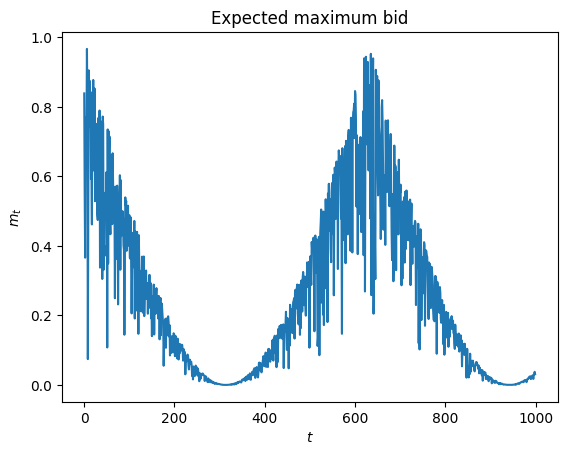

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

from environment import Environment
from bidding_environment import FirstPriceAuction
from bidding import HedgeAgent, FFMultiplicativePacingAgent
from pricing import UCB1PricingAgent, EXP3Agent
from pricing_environment import PricingEnvironment
from Demand_curve_generator import Demand_curve_generator as demand
import warnings
warnings.filterwarnings("ignore")

### Adversarial Bidders

n_advertisers = 3
n_users = 1000
B = 150
my_valuation = 0.6
rho = B/n_users

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 1-np.abs(np.sin(5*t/n_users))
other_bids = np.array([np.random.uniform(0, pattern(t), size = n_advertisers) for t in range(n_users)]).T
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

m_t = other_bids.max(axis=0)

plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

In [28]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = FirstPriceAuction(np.ones(n_advertisers+1))

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 561


In [29]:
n_epochs = 50
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = FirstPriceAuction(np.ones(n_advertisers+1))
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

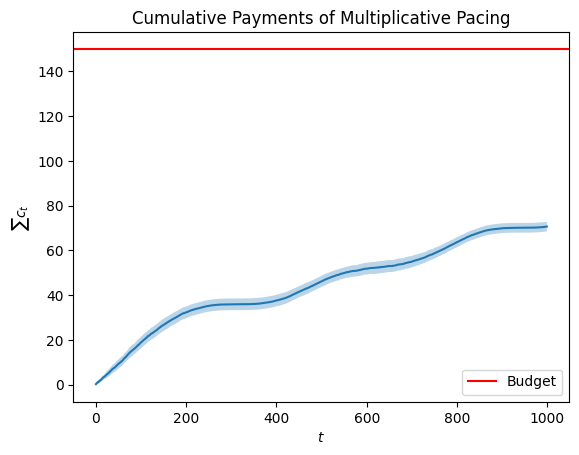

In [30]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

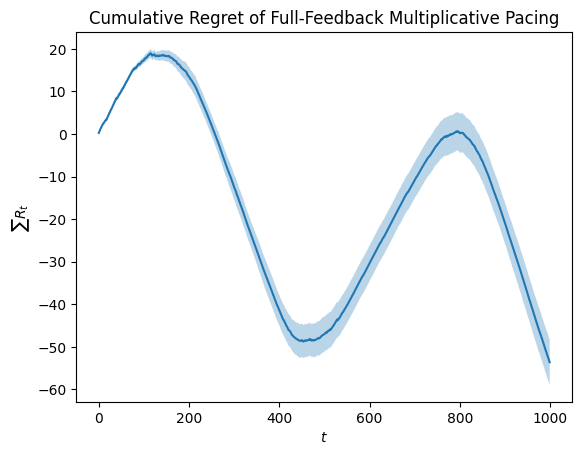

In [31]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

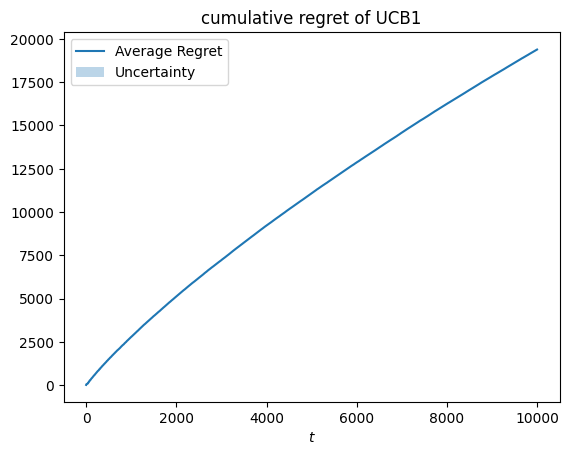

In [32]:
# Pricing agent (UCB1) 

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    T = 10000 # number of days
    epsilon = T**(-0.33)
    K = int(1/epsilon) # discretization prescribed by the theory 
    n_customers = 100 #this would depend on advertising step

    prices = np.linspace(0,1,K) # 100 actions
    cost = 0.1 #To be chosen

    conversion_rates = []
    random_steeps = np.random.uniform(1,5,T) #generates T parameters for the demand curve 1 for each day (ask if it could be more than one per day)
    conversion_rates = [demand.generate_demand(0,1,steep) for steep in random_steeps]

    reward_function = lambda price, n_sales: (price-cost)*n_sales
    maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer


    profit_curve = []
    for t in range(T):
        profit_curve.append(reward_function(prices, n_customers*conversion_rates[t](prices)))
    profit_curve = np.array(profit_curve)
    summed_profits = np.sum(profit_curve, axis=0)
    best_price_index = np.argmax(summed_profits)
    best_price = prices[best_price_index]
    expected_clairvoyant_rewards = profit_curve[:,best_price_index]

    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_rates, cost=cost)
    ucb_agent = UCB1PricingAgent(K, T, range=maximum_profit) #TODO I think we should use an adverarial regret minimizer here like exp3!!!

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        d_t, r_t = env.round(p_t, n_customers, t)# modified envirnment function!!!
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

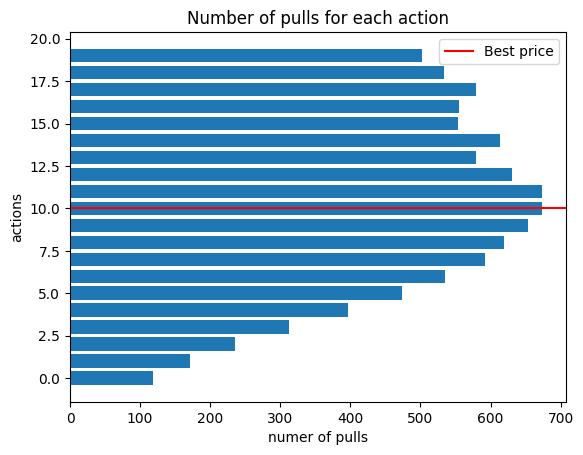

In [33]:
plt.figure()
plt.barh(np.arange(K), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

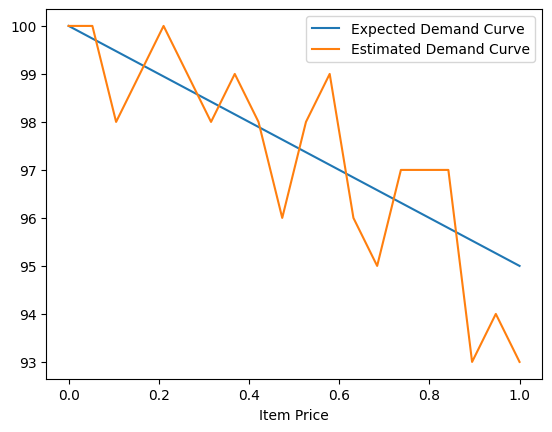

In [34]:
expected_demand_curve = n_customers*conversion_probability(prices)

estimated_demand_curve = np.random.binomial(n_customers, conversion_probability(prices))

plt.figure()
plt.plot(prices, expected_demand_curve, label='Expected Demand Curve')
plt.plot(prices, estimated_demand_curve, label='Estimated Demand Curve')
plt.xlabel('Item Price')
plt.legend()
plt.show();

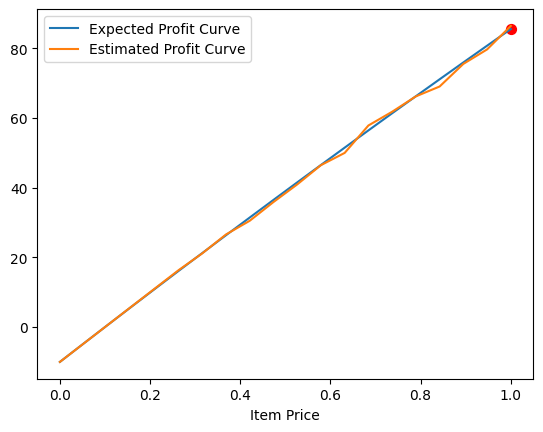

In [39]:
expected_profit_curve = n_customers*conversion_probability(prices)*(prices-cost)

estimated_profit_curve = np.random.binomial(n_customers, conversion_probability(prices))*(prices-cost)

best_price_index = np.argmax(expected_profit_curve)
best_price = prices[best_price_index]

plt.figure()
plt.plot(prices, expected_profit_curve, label='Expected Profit Curve')
plt.plot(prices, estimated_profit_curve, label='Estimated Profit Curve')
plt.scatter(best_price, expected_profit_curve[best_price_index], color='red', s=50)
plt.xlabel('Item Price')
plt.legend()
plt.show();

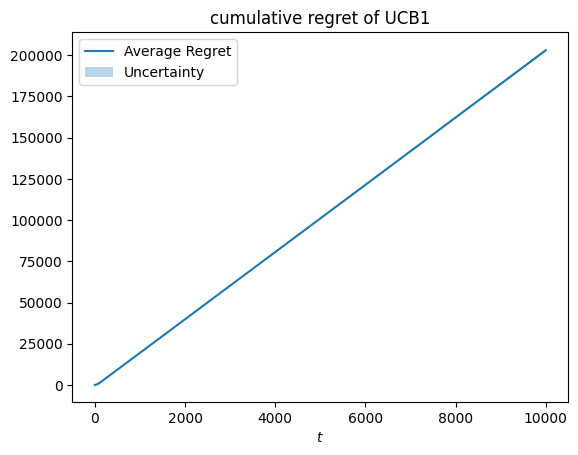

In [3]:
# Pricing agent (EXP3) 

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    T = 10000 # number of days
    epsilon = T**(-0.33)
    K = int(1/epsilon) # discretization prescribed by the theory 
    n_customers = 100 #this would depend on advertising step
    learning_rate = np.sqrt(np.log(K)/(K*T))

    prices = np.linspace(0,1,K) # 100 actions
    cost = 0.1 #To be chosen

    conversion_rates = []
    random_steeps = np.random.uniform(1,5,T) #generates T parameters for the demand curve 1 for each day (ask if it could be more than one per day)
    conversion_rates = [demand.generate_demand(0,1,steep) for steep in random_steeps]

    reward_function = lambda price, n_sales: (price-cost)*n_sales
    maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer


    profit_curve = []
    for t in range(T):
        profit_curve.append(reward_function(prices, n_customers*conversion_rates[t](prices)))
    profit_curve = np.array(profit_curve)
    summed_profits = np.sum(profit_curve, axis=0)
    best_price_index = np.argmax(summed_profits)
    best_price = prices[best_price_index]
    expected_clairvoyant_rewards = profit_curve[:,best_price_index]

    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_rates, cost=cost)
    ucb_agent = EXP3Agent(K, learning_rate) #TODO I think we should use an adverarial regret minimizer here like exp3!!!

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        d_t, r_t = env.round(p_t, n_customers, t)# modified envirnment function!!!
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

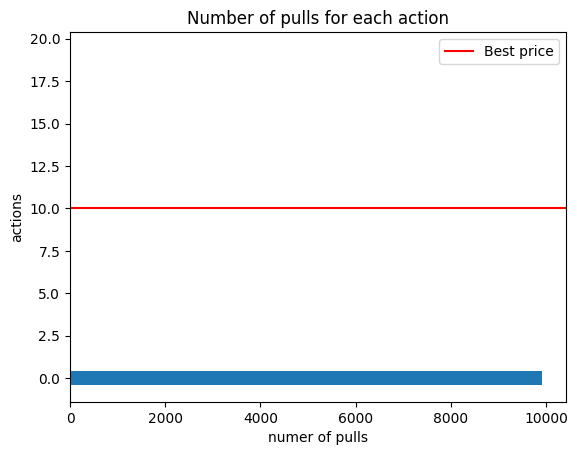

In [4]:
plt.figure()
plt.barh(np.arange(K), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();